In [1]:
import pandas as pd
import numpy as np

In [2]:
products = pd.read_csv('amazon_baby_subset.csv')

In [3]:
products.head()

,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago. ...,5,1
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1


**Fill /na values in the review column with empty strings**

In [4]:
products = products.fillna({'review': ''})

In [5]:
import string

table = str.maketrans({c : '' for c in string.punctuation})

def remove_punctuation(text):
    return text.translate(table)

In [6]:
products['review_clean'] = products['review'].apply(remove_punctuation)

In [7]:
import json

with open('important_words.json') as fp:
    important_words = json.load(fp)

In [8]:
for word in important_words:
    products[word] = products['review_clean'].apply(lambda s : s.split().count(word))

### Train-Validation split

In [9]:
with open('module-4-assignment-train-idx.json') as fp:
    train_indices = json.load(fp)

train_data = products.iloc[train_indices]

In [10]:
with open('module-4-assignment-validation-idx.json') as fp:
    validation_indices = json.load(fp)

validation_data = products.iloc[validation_indices]

### Convert data frame to multi-dimensional array

In [11]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    return (dataframe[features].as_matrix(), dataframe[label].as_matrix())

In [12]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')

feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
def predict_probability(feature_matrix, coefficients):
    score = np.dot(feature_matrix, coefficients)
    
    predictions = 1 / (1. + np.exp(-score))
    
    return predictions

### Adding L2 penalty to the derivative

In [14]:
def feature_derivative_with_L2(errors, features, coefficient, l2_penalty, feature_is_constant):
    derivative = np.dot(errors, features)
    if not feature_is_constant:
        derivative -= 2 * l2_penalty * coefficient
    return derivative

In [15]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment == 1)
    scores = np.dot(feature_matrix, coefficients)
    lp = np.sum((indicator-1) * scores - np.log(1. + np.exp(-scores))) \
       - l2_penalty * np.sum(coefficients[1:]**2)
    return lp

### Taking gradient steps

In [16]:
from math import sqrt

def logistic_regression(features,
                        label,
                        coefficients,
                        step_size,
                        l2_penalty,
                        max_iter):
#     print(features.shape)
#     print(coefficients.shape)

    for i in range(max_iter):
        predictions = predict_probability(features, coefficients)

        indicator = (label == +1)
        
        errors = indicator - predictions

        for j in range(len(coefficients)):
            derivative = feature_derivative_with_L2(errors,
                                                    features[:,j],
                                                    coefficients[j],
                                                    l2_penalty,
                                                    j == 0)
            coefficients[j] = coefficients[j] + (step_size * derivative)
        

        # Checking whether log likelihood is increasing
#         if i <= 15 or (i <= 100 and i % 10 == 0) or (i <= 1000 and i % 100 == 0) or (i <= 10000 and i % 1000 == 0) or i % 10000 == 0:
#             lp = compute_log_likelihood_with_L2(features, label, coefficients, l2_penalty)
#             print('iteration %*d: log likelihood of observed labels = %.8f' %
#                   (int(np.ceil(np.log10(max_iter))), i, lp))

    return coefficients

In [17]:
initial_coefficients = np.zeros(194)

In [18]:
coefficients_0_penalty = logistic_regression(feature_matrix_train,
                                             sentiment_train,
                                             np.zeros(194),
                                             5e-6,
                                             0,
                                             501)

coefficients_4_penalty = logistic_regression(feature_matrix_train,
                                             sentiment_train,
                                             np.zeros(194),
                                             5e-6,
                                             4,
                                             501)

coefficients_10_penalty = logistic_regression(feature_matrix_train,
                                              sentiment_train,
                                              np.zeros(194),
                                              5e-6,
                                              10,
                                              501)

coefficients_1e2_penalty = logistic_regression(feature_matrix_train,
                                               sentiment_train,
                                               np.zeros(194),
                                               5e-6,
                                               1e2,
                                               501)

coefficients_1e3_penalty = logistic_regression(feature_matrix_train,
                                               sentiment_train,
                                               np.zeros(194),
                                               5e-6,
                                               1e3,
                                               501)

coefficients_1e5_penalty = logistic_regression(feature_matrix_train,
                                               sentiment_train,
                                               np.zeros(194),
                                               5e-6,
                                               1e5,
                                               501)

### Compare coefficients

In [26]:
coefficients_0_penalty_nointercept = list(coefficients_0_penalty[1:])

words_with_coefficients = sorted(zip(important_words, coefficients_0_penalty_nointercept), key=lambda x: x[1], reverse=True)

In [27]:
positive_words_top5 = [p[0] for p in words_with_coefficients[:5]]

print(positive_words_top5)

['love', 'loves', 'easy', 'perfect', 'great']


In [31]:
negative_words_top5 = [p[0] for p in reversed(words_with_coefficients[-5:])]

print(negative_words_top5)

['disappointed', 'money', 'return', 'waste', 'returned']


In [59]:
data = [ coefficients_0_penalty
       , coefficients_4_penalty
       , coefficients_10_penalty
       , coefficients_1e2_penalty
       , coefficients_1e3_penalty
       , coefficients_1e5_penalty
       ]

l2_penalty_list = [0, 4, 10, 1e2, 1e3, 1e5]

table = dict(zip(l2_penalty_list, data))

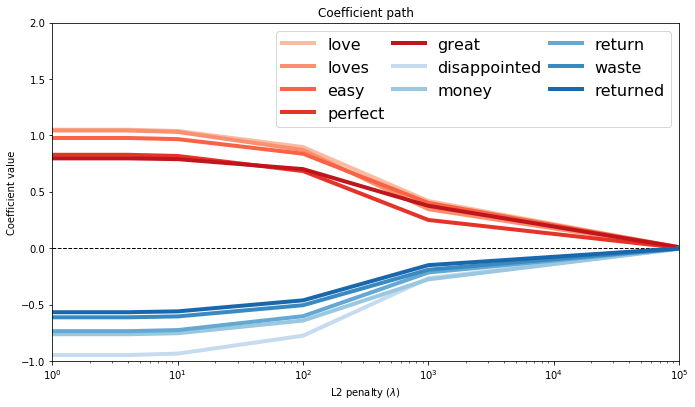

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(positive_words, negative_words, table):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    plt.plot(l2_penalty_list, [0.]*len(l2_penalty_list), '--', lw=1, color='k')

    for i in range(len(positive_words)):
        word = positive_words[i]
        color = cmap_positive(0.8 * ((i+1) / (len(positive_words)*1.2) + 0.15))
        plt.plot(table.keys(),
                 [v[important_words.index(word) + 1] for v in table.values()],
                 '-',
                 label=word,
                 linewidth=4.0,
                 color=color)

    for i in range(len(negative_words)):
        word = negative_words[i]
        color = cmap_negative(0.8 * ((i+1) / (len(negative_words)*1.2) + 0.15))
        plt.plot(table.keys(),
                 [v[important_words.index(word) + 1] for v in table.values()],
                 '-',
                 label=word,
                 linewidth=4.0,
                 color=color)

    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(positive_words_top5, negative_words_top5, table)


### Measuring accuracy

In [66]:
def calc_accuracy(features, coefficients, labels):
    scores = np.dot(features, coefficients)
    df = pd.DataFrame({ 'sentiment': labels })
    df['predicted_sentiment'] = [1 if s > 0 else -1 for s in scores]
    df['is_correct'] = (df['predicted_sentiment'] - df['sentiment']).apply(lambda x: True if x == 0 else False)
    return df[df['is_correct'] == True]['is_correct'].size / df['is_correct'].size

In [71]:
# train data

for k, v in table.items():
    accuracy = calc_accuracy(feature_matrix_train, v, sentiment_train)
    print('%-10s\t%f' % (k, accuracy))

0         	0.785156
4         	0.785109
10        	0.784991
100.0     	0.783976
1000.0    	0.775855
100000.0  	0.680366


In [72]:
# validation data

for k, v in table.items():
    accuracy = calc_accuracy(feature_matrix_valid, v, sentiment_valid)
    print('%-10s\t%f' % (k, accuracy))

0         	0.781440
4         	0.781533
10        	0.781720
100.0     	0.781066
1000.0    	0.771357
100000.0  	0.667818
